# Bayesian Networks and Flight Delay : SFO to PHL

Flight delay is a costly problem to consumers, airlines, and industrial experts. Delays provoke complaints from passengers, create high costs to airlines, and result in difficulties for airport operations. It is therefore important for the Federal Aviation Administration (FAA) to understand the causes of delay as a means to reduce the total cost that delays can cause.

Known factors that cause flight delays include weather at the origin airport, congestion at the origin airport, and air traffic management (ATM) decisions such as Ground Delay Programs (GDP). Each component interacts with other components in complex ways, which is why flight delays are an inherently stochastic phenomenon. Simply examining the marginal distributions of such factor does not truly reveal the effects that such factors have or the relationship between any two of such factors.

Here, we will perform a case study of the use of Bayesian networks to model the relationship between different components of aircraft delay and the causal factors that affect delays. Bayesian networks allow us to simultaneously examine multiple components of delay and their relationships in a single analysis, an advantage that the use of Bayesian networks has over linear and nonlinear regression models. Moreover, Bayesian network models provide not only just predictions of future delays that incorporate the interrelationships among causal factors, but also a means of assessing the ultimate influence each causal factors has on arrival delay.

In particular, we will examine delays in flight from San Francisco International Airport (SFO) to Philadelphia International Airport (PHL).

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
import calendar
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def filterRoutes(df):
    '''
    filter df to contain delayed fligths from SFO to PHL routes only.
    '''
    df = df[(df['ORIGIN'] == 'SFO') & (df['DEST'] == 'PHL') & (df['ARR_DELAY'] > 0)]
    df = df.reset_index()
    return df.drop(['index','YEAR','ORIGIN','DEST', 'UNIQUE_CARRIER','DEP_TIME','DEP_TIME_BLK','DEP_DELAY_GROUP', 'DEP_DELAY_NEW', 'DEP_DEL15','WHEELS_OFF','WHEELS_ON','ARR_DELAY','ARR_DELAY_NEW','Unnamed: 29'],axis=1)

def dateColumns(df):
    '''
    Given a column with mm/dd/yyyy, create a MONTH and DAY column.
    '''
    dates = [str(d).replace('/','') for d in list(df['Date'])]
    dates = [time.strptime(d,'%m%d%Y') for d in dates]
    df['MONTH'] = [d.tm_mon for d in dates]
    df['DAY'] = [d.tm_mday for d in dates]

## The Nitty-Gritty: Preparing the Data

### Read and Merge

We are working with two datasets. The first is provided by the Bureau of Transportation Statistics and contains flight information, including Common Reporting Standard (CRS) arrival and departure times, causes of delay, and time spend taxiing in and out. We will start by reading in twelve months' worth of data and filtering for just the SFO to PHL routes.

In [3]:
# read data and filter for relevant delayed flights
jan_df = filterRoutes(pd.read_csv('./month/jan2017.csv'))
feb_df = filterRoutes(pd.read_csv('./month/feb2017.csv'))
mar_df = filterRoutes(pd.read_csv('./month/mar2017.csv'))
apr_df = filterRoutes(pd.read_csv('./month/apr2017.csv'))
may_df = filterRoutes(pd.read_csv('./month/may2017.csv'))
jun_df = filterRoutes(pd.read_csv('./month/jun2017.csv'))
jul_df = filterRoutes(pd.read_csv('./month/jul2017.csv'))
aug_df = filterRoutes(pd.read_csv('./month/aug2017.csv'))
sep_df = filterRoutes(pd.read_csv('./month/sep2017.csv'))
oct_df = filterRoutes(pd.read_csv('./month/oct2017.csv'))
nov_df = filterRoutes(pd.read_csv('./month/nov2017.csv'))
dec_df = filterRoutes(pd.read_csv('./month/dec2017.csv'))

# concatenate dataframes by quarter
flights_df = pd.concat([jan_df, feb_df,mar_df,apr_df, may_df, jun_df, jul_df, aug_df, sep_df, oct_df, nov_df, dec_df])

# keep hour information from CRS but not minutes
flights_df['CRS_DEP_TIME'] = flights_df['CRS_DEP_TIME'] // 100
flights_df['CRS_ARR_TIME'] = flights_df['CRS_ARR_TIME'] // 100

Secondly, we will read in the data provided by the Federal Aviation Administration (FAA) on airport situations in SFO and PHL in 2017 in 'ASPM : Airport Analysis : Delayed Flights Report.' After reading in the data, we will merge the two dataframes to create one flights_df dataframe.

In [4]:
airports_df = pd.read_csv('./faa-aspm/airports.csv').dropna(axis=0,how='all')

# split Date into MONTH and DAY
airports_df['Facility'] = airports_df['Facility'].str.strip()
dateColumns(airports_df)
airports_df = airports_df.drop(['Date','% DelayedGateDepartures','% DelayedGateArrivals','Date'],axis=1)
airports_df = airports_df.drop(['DeparturesFor MetricComputation','ArrivalsFor MetricComputation','AverageMinutesOf DelayPer DelayedGateDeparture','AverageMinutesOf DelayPer DelayedGateArrival'],axis=1)

# find departure and arrival informations at airport at time of departure/arrival
# SFO (departure)
flights_SFO_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_SFO_df = flights_SFO_df[flights_SFO_df['Facility'] == 'SFO']
# PHL (arrival)
flights_PHL_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_PHL_df = flights_PHL_df[flights_PHL_df['Facility'] == 'PHL']
# set departure/arrival information as fields of flights_df
flights_df['DelayedDepartureSFO'] = flights_PHL_df['DelayedGateDepartures']
flights_df['ScheduledDepartureSFO'] = flights_PHL_df['ScheduledDepartures']
flights_df['DelayedArrivalPHL'] = flights_PHL_df['DelayedGateArrivals']
flights_df['ScheduledArrivalPHL'] = flights_PHL_df['ScheduledArrivals']
flights_df.fillna(0,inplace=True)
flights_df = flights_df.reset_index()
flights_df = flights_df.drop(['index'],axis=1)

We no longer need information about DAY_OF_MONTH, so we will drop that column. The compiled data is as below. Due to the length of each field name, we transpose the dataframe for readability.

In [5]:
flights_df = flights_df.drop(['DAY_OF_MONTH'],axis=1)
flights_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
QUARTER,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
MONTH,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
DAY_OF_WEEK,3.0,6.0,4.0,6.0,7.0,1.0,2.0,4.0,5.0,4.0,...,4.0,4.0,3.0,2.0,1.0,2.0,1.0,7.0,5.0,4.0
CRS_DEP_TIME,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,...,15.0,8.0,8.0,8.0,8.0,8.0,22.0,22.0,8.0,22.0
DEP_DELAY,28.0,90.0,32.0,24.0,-1.0,0.0,-9.0,17.0,2.0,1.0,...,81.0,23.0,-1.0,-6.0,14.0,10.0,-5.0,0.0,35.0,0.0
TAXI_OUT,26.0,12.0,17.0,16.0,29.0,16.0,19.0,24.0,23.0,31.0,...,20.0,29.0,39.0,36.0,45.0,21.0,29.0,27.0,29.0,27.0
TAXI_IN,3.0,5.0,4.0,6.0,4.0,6.0,5.0,3.0,3.0,7.0,...,5.0,6.0,5.0,5.0,8.0,11.0,11.0,7.0,10.0,5.0
CRS_ARR_TIME,6.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,0.0,17.0,16.0,16.0,16.0,16.0,7.0,7.0,16.0,7.0
ARR_DEL15,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
DIVERTED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train and Test Data

Let the five delay causes (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY) and the variable we are looking to explain (ARR_DEL15) be nodes. We must perform regression analysis to determine dependency relationships.

In [6]:
# 20% test data
from sklearn.model_selection import train_test_split
# 774 train data, 194 test data
train_df,test_df = train_test_split(flights_df, test_size=0.2)

## Finding Dependencies: Regression Analysis

We use the Ordinary Least Squares (OLS) method to find dependencies, starting with what we know to be the final outcome: ARR_DEL15 (which is 0 if the flight does not arrive more than 15 minutes late, 1 otherwise). As we find dependencies, we will also be making sure that we are not creating any accidental cycles.

### ARR_DEL15

In [7]:
arr_15_from = ['CRS_DEP_TIME','DEP_DELAY','CRS_ARR_TIME','CARRIER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
X = train_df[arr_15_from]
y = train_df['ARR_DEL15']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DEL15   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     375.2
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          2.09e-224
Time:                        04:37:34   Log-Likelihood:                -330.98
No. Observations:                 774   AIC:                             674.0
Df Residuals:                     768   BIC:                             701.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME            0.0151      0.001     11.662      0.000       0.013       0.018
DEP_DELAY              -0.0038      0.001     -4.667      0.000      -0.005      -0.002
CRS_ARR_TIME            0.0081      0.001      5.738      0.000       0.005       0.011
CARRIER_DELAY           0.0112      0.001     10.603      0.000       0.009       0.013
NAS_DELAY               0.0135      0.001     17.825      0.000       0.012       0.015
LATE_AIRCRAFT_DELAY     0.0120      0.001     10.550      0.000       0.010       0.014
==============================================================================
Omnibus:                        4.015   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                3.883
Skew:                          -0.170   Prob(JB):                        0.144
Kurtosis:                       3.073   Cond. No.                         6.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

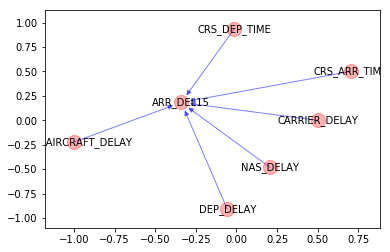

In [8]:
# update flights_edges_df with from_node to to_node entries
flights_edges_dict = dict()
for node in arr_15_from:
    flights_edges_dict[node] = 'ARR_DEL15'
flight_edges_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
plt.show()

Using regressional analysis, we conclude that ARR_DEL15 is dependent on six factors. So far, we do not have any cycles (remember that a Bayesian network consists of a directed acyclic graph), so we may proceed by moving onto finding more dependencies by choosing an arbitrary parent of ARR_DEL15.

### NAS Delay

Carrier Delay depends on

In [9]:
nas_delay_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','CARRIER_DELAY','WEATHER_DELAY','LATE_AIRCRAFT_DELAY',]

X = train_df[nas_delay_from]
y = train_df['NAS_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NAS_DELAY   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     160.1
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          2.57e-169
Time:                        04:37:34   Log-Likelihood:                -3067.5
No. Observations:                 774   AIC:                             6153.
Df Residuals:                     765   BIC:                             6195.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                -1.6679      0.417     -4.002      0.000      -2.486      -0.850
CRS_DEP_TIME           -0.6837      0.067    -10.252      0.000      -0.815      -0.553
DEP_DELAY               0.6636      0.028     23.729      0.000       0.609       0.719
TAXI_OUT                0.8510      0.041     20.767      0.000       0.771       0.931
TAXI_IN                 0.8638      0.053     16.244      0.000       0.759       0.968
CRS_ARR_TIME           -0.7735      0.076    -10.123      0.000      -0.923      -0.623
DIVERTED            -2.772e-16   7.03e-17     -3.944      0.000   -4.15e-16   -1.39e-16
CARRIER_DELAY          -0.6998      0.036    -19.617      0.000      -0.770      -0.630
WEATHER_DELAY          -0.6107      0.081     -7.541      0.000      -0.770      -0.452
LATE_AIRCRAFT_DELAY    -0.7300      0.038    -19.121      0.000      -0.805      -0.655
==============================================================================
Omnibus:                      117.269   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              248.478
Skew:                           0.858   Prob(JB):                     1.11e-54
Kurtosis:                       5.182   Cond. No.                     7.31e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.11e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

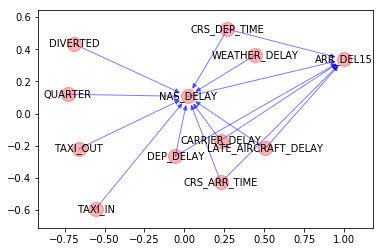

In [10]:
# update flights_edges_df with from_node to to_node entries
flights_edges_dict = dict()
for node in nas_delay_from:
    flights_edges_dict[node] = 'NAS_DELAY'
temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
flight_edges_df = flight_edges_df.drop(['index'], axis=1)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
plt.show()

Now, we check to make sure there are no cycles. The find_cycle function in networkx will return a list of edges for an existing cycle.

In [11]:
try:
    nx.find_cycle(bn, source=None, orientation='original')
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### Late Aircraft Delay

Now, we took a look at the variables that LATE_AIRCRAFT_DELAY rely on.

In [12]:
late_aircraft_from = ['MONTH','DEP_DELAY','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY']
X = train_df[late_aircraft_from]
y = train_df['LATE_AIRCRAFT_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LATE_AIRCRAFT_DELAY   R-squared:                       0.767
Model:                             OLS   Adj. R-squared:                  0.766
Method:                  Least Squares   F-statistic:                     507.2
Date:                 Thu, 29 Mar 2018   Prob (F-statistic):          1.26e-240
Time:                         04:37:35   Log-Likelihood:                -2962.6
No. Observations:                  774   AIC:                             5935.
Df Residuals:                      769   BIC:                             5958.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MONTH             0.3366      0.060      5.642      0.000       0.220       0.454
DEP_DELAY         0.6304      0.013     47.327      0.000       0.604       0.657
CARRIER_DELAY    -0.6880      0.023    -30.277      0.000      -0.733      -0.643
WEATHER_DELAY    -0.6432      0.068     -9.508      0.000      -0.776      -0.510
NAS_DELAY        -0.2509      0.021    -12.034      0.000      -0.292      -0.210
==============================================================================
Omnibus:                      277.191   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10818.400
Skew:                          -0.894   Prob(JB):                         0.00
Kurtosis:                      21.228   Cond. No.                         8.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

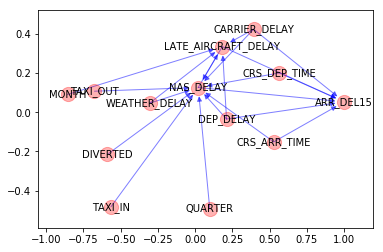

In [13]:
# update flights_edges_df with from_node to to_node entries
flights_edges_dict = dict()
for node in late_aircraft_from:
    flights_edges_dict[node] = 'LATE_AIRCRAFT_DELAY'
temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
flight_edges_df = flight_edges_df.drop(['index'], axis=1)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
plt.show()

Again, we check for cycles:

In [14]:
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('NAS_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'NAS_DELAY')]


Since __NAS_DELAY__ and __LATE_AIRCRAFT_DELAY__ have edges pointing to each other, we must decide which edge we are going to get rid of. The FAA (http://aspmhelp.faa.gov/index.php/Types_of_Delay) defines __NAS_DELAY__ as delay that is "within the control of the National Airspace System (NAS)," including "non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc." It goes on to state that delays at the destination airport that occur after Actual Gate Out time are attributed to the NAS (such as gate in delay and taxi in delay). On the other hand, FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. That is, the two seem to have no direct relationship with one another at all. Therefore, we remove both edges.

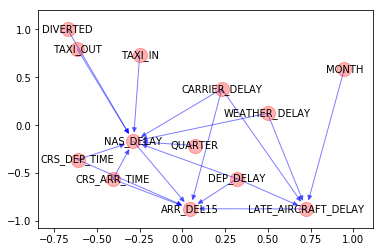

In [15]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'NAS_DELAY') | (flight_edges_df.to_node != 'LATE_AIRCRAFT_DELAY')]
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'LATE_AIRCRAFT_DELAY') | (flight_edges_df.to_node != 'NAS_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
plt.show()

In [16]:
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### Carrier Delay

In [17]:
carrier_delay_from = ['CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
X = train_df[carrier_delay_from]
y = train_df['CARRIER_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     401.0
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          7.45e-268
Time:                        04:37:35   Log-Likelihood:                -2920.6
No. Observations:                 774   AIC:                             5857.
Df Residuals:                     766   BIC:                             5894.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME           -0.4741      0.052     -9.034      0.000      -0.577      -0.371
DEP_DELAY               0.7456      0.014     53.092      0.000       0.718       0.773
TAXI_OUT                0.4764      0.037     12.891      0.000       0.404       0.549
TAXI_IN                 0.4888      0.047     10.348      0.000       0.396       0.582
CRS_ARR_TIME           -0.5737      0.061     -9.431      0.000      -0.693      -0.454
DIVERTED             6.703e-16   5.05e-17     13.282      0.000    5.71e-16    7.69e-16
WEATHER_DELAY          -0.7148      0.064    -11.102      0.000      -0.841      -0.588
NAS_DELAY              -0.4750      0.024    -19.716      0.000      -0.522      -0.428
LATE_AIRCRAFT_DELAY    -0.8364      0.023    -35.738      0.000      -0.882      -0.790
==============================================================================
Omnibus:                      160.411   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1806.740
Skew:                          -0.576   Prob(JB):                         0.00
Kurtosis:                      10.396   Cond. No.                     6.28e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.33e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
flights_edges_dict = dict()
for node in carrier_delay_from:
    flights_edges_dict[node] = 'CARRIER_DELAY'
temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
flight_edges_df = flight_edges_df.drop(['index'], axis=1)

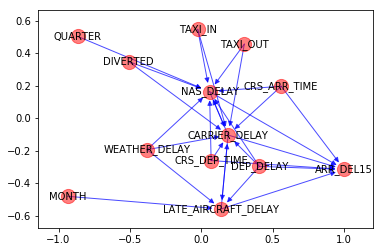

In [19]:
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.5)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.7)
# nx.draw_networkx_edges(bn, pos, edgelist=black_edges, arrows=False)
plt.show()

In [20]:
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('NAS_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'NAS_DELAY')]


__CARRIER_DELAY__ is within the control of the air carrier, such as: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays. This seems to have little to do with __NAS_DELAY__ and vice versa. Thus, we remove both edges

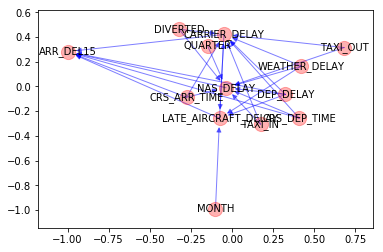

In [21]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'NAS_DELAY') | (flight_edges_df.to_node != 'CARRIER_DELAY')]
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'CARRIER_DELAY') | (flight_edges_df.to_node != 'NAS_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
plt.show()

In [22]:
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]


Recall that FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. It would seem probable that a late prior aircraft could cause carrier delay but not the other way around. Thus, we only remove the edge from CARRIER_DELAY to LATE_AIRCRAFT_DELAY.

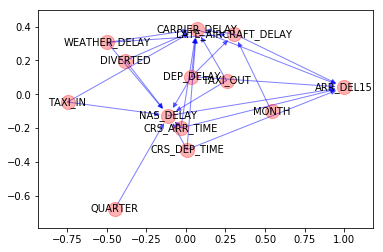

In [23]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'CARRIER_DELAY') | (flight_edges_df.to_node != 'LATE_AIRCRAFT_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
plt.show()

In [24]:
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### WEATHER_DELAY

Though not ideal in p-value, CRS_DEP_TIME seems like the only likely variable which WEATHER_DELAY may be dependent on.

In [25]:
weather_delay_from = ['CRS_DEP_TIME']
X = train_df[weather_delay_from]
y = train_df['WEATHER_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          WEATHER_DELAY   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.715
Date:                Thu, 29 Mar 2018   Prob (F-statistic):             0.0998
Time:                        04:37:36   Log-Likelihood:                -2489.1
No. Observations:                 774   AIC:                             4980.
Df Residuals:                     773   BIC:                             4985.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CRS_DEP_TIME     0.0238      0.014      1.648      0.100      -0.005       0.052
==============================================================================
Omnibus:                     2020.177   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18169971.885
Skew:                          27.246   Prob(JB):                         0.00
Kurtosis:                     751.626   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

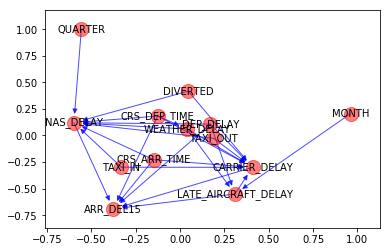

In [26]:
flights_edges_dict = dict()
for node in weather_delay_from:
    flights_edges_dict[node] = 'WEATHER_DELAY'
temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
flight_edges_df = flight_edges_df.drop(['index'], axis=1)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.5)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.7)
# nx.draw_networkx_edges(bn, pos, edgelist=black_edges, arrows=False)
plt.show()

In [27]:
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### Security Delay

Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

In [29]:
security_delay_from = ['DAY_OF_WEEK','DEP_DELAY','TAXI_OUT','CARRIER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
X = train_df[security_delay_from]
y = train_df['SECURITY_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SECURITY_DELAY   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3.143
Date:                Thu, 29 Mar 2018   Prob (F-statistic):            0.00475
Time:                        04:37:37   Log-Likelihood:                -1644.0
No. Observations:                 774   AIC:                             3300.
Df Residuals:                     768   BIC:                             3328.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
DAY_OF_WEEK            -0.0621      0.031     -2.014      0.044      -0.123      -0.002
DEP_DELAY               0.0169      0.005      3.611      0.000       0.008       0.026
TAXI_OUT                0.0111      0.005      2.330      0.020       0.002       0.020
CARRIER_DELAY          -0.0186      0.006     -3.120      0.002      -0.030      -0.007
NAS_DELAY              -0.0109      0.005     -2.350      0.019      -0.020      -0.002
LATE_AIRCRAFT_DELAY    -0.0136      0.006     -2.108      0.035      -0.026      -0.001
==============================================================================
Omnibus:                     2007.722   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17496602.151
Skew:                          26.826   Prob(JB):                         0.00
Kurtosis:                     737.610   Cond. No.                         22.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

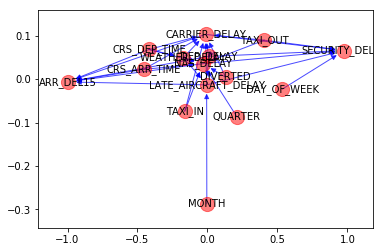

In [30]:
flights_edges_dict = dict()
for node in security_delay_from:
    flights_edges_dict[node] = 'SECURITY_DELAY'
temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
flight_edges_df = flight_edges_df.drop(['index'], axis=1)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.5)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.7)
# nx.draw_networkx_edges(bn, pos, edgelist=black_edges, arrows=False)
plt.show()

In [31]:
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### QUARTER

We come to a rather odd conclusion that CRS_DEP_TIME and CRS_ARR_TIME may directly influence QUARTER.

In [48]:
quarter_from = [
 'MONTH',
 'CRS_DEP_TIME',
 'CRS_ARR_TIME',
]
X = train_df[quarter_from]
y = train_df['QUARTER']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                QUARTER   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.636e+04
Date:                Thu, 29 Mar 2018   Prob (F-statistic):               0.00
Time:                        04:43:23   Log-Likelihood:                -114.98
No. Observations:                 774   AIC:                             236.0
Df Residuals:                     771   BIC:                             249.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
MONTH            0.3218      0.003    110.292      0.000       0.316       0.328
CRS_DEP_TIME     0.0111      0.001      9.138      0.000       0.009       0.013
CRS_ARR_TIME     0.0178      0.001     14.596      0.000       0.015       0.020
==============================================================================
Omnibus:                     1343.006   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.742
Skew:                           0.083   Prob(JB):                     1.30e-12
Kurtosis:                       1.708   Cond. No.                         6.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

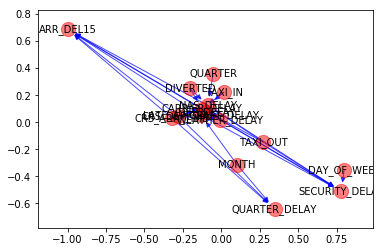

In [49]:
flights_edges_dict = dict()
for node in quarter_from:
    flights_edges_dict[node] = 'QUARTER_DELAY'
temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
flight_edges_df = flight_edges_df.drop(['index'], axis=1)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
# draw graph
bn_edges = [edge for edge in bn.edges()]
pos = nx.spring_layout(bn)
nx.draw_networkx_nodes(bn, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.5)
nx.draw_networkx_labels(bn, pos,font_size='10')
nx.draw_networkx_edges(bn, pos, edgelist=bn_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.7)
# nx.draw_networkx_edges(bn, pos, edgelist=black_edges, arrows=False)
plt.show()

In [50]:
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


In [28]:
[
'QUARTER',
 'MONTH',
 'DAY_OF_WEEK',
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_DEL15',
 'DIVERTED',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'DelayedDepartureSFO',
 'ScheduledDepartureSFO',
 'DelayedArrivalPHL',
 'ScheduledArrivalPHL'
]

['QUARTER',
 'MONTH',
 'DAY_OF_WEEK',
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_DEL15',
 'DIVERTED',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'DelayedDepartureSFO',
 'ScheduledDepartureSFO',
 'DelayedArrivalPHL',
 'ScheduledArrivalPHL']

[
 'MONTH',
 'DAY_OF_WEEK',
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'DIVERTED',
 'DelayedDepartureSFO',
 'ScheduledDepartureSFO',
 'DelayedArrivalPHL',
 'ScheduledArrivalPHL'
]